# Loading the dataset from Kaggle

In [ ]:
!pip install kagglehub


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:


import kagglehub

# Download latest version
path = kagglehub.dataset_download("victorcallejasf/multimodal-hate-speech")

print("Path to dataset files:", path)

c:\Users\100ab\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 5.97G/5.97G [22:02<00:00, 4.84MB/s]  

Extracting files...


Path to dataset files: C:\Users\100ab\.cache\kagglehub\datasets\victorcallejasf\multimodal-hate-speech\versions\1


## Dataset path

In [1]:
ls C:\Users\100ab\.cache\kagglehub\datasets\victorcallejasf\multimodal-hate-speech\versions\1

 Volume in drive C is OsDrive
 Volume Serial Number is A6E5-62C0

 Directory of C:\Users\100ab\.cache\kagglehub\datasets\victorcallejasf\multimodal-hate-speech\versions\1

04/01/2025  01:17 PM    <DIR>          .
04/01/2025  01:04 PM    <DIR>          ..
04/01/2025  01:04 PM               952 hatespeech_keywords.txt
04/01/2025  01:15 PM    <DIR>          img_resized
04/01/2025  01:17 PM    <DIR>          img_txt
04/01/2025  01:04 PM        51,426,208 MMHS150K_GT.json
04/01/2025  01:04 PM             1,079 MMHS150K_readme.txt
04/01/2025  01:17 PM    <DIR>          splits
               3 File(s)     51,428,239 bytes
               5 Dir(s)  25,473,847,296 bytes free


# Loading the json dataset file

In [54]:
import pandas as pd
import json


# loading Json file
df = pd.read_json(
    r"C:\Users\100ab\.cache\kagglehub\datasets\victorcallejasf\multimodal-hate-speech\versions\1\MMHS150K_GT.json", 
    orient="index"
)
print(df.head())

                                                                         img_url  \
2005-04-28 09:09:13.714016256  http://pbs.twimg.com/tweet_video_thumb/D3gi9MH...   
2003-09-08 11:20:48.816660480  http://pbs.twimg.com/ext_tw_video_thumb/106301...   
2005-02-20 19:22:48.075374593     http://pbs.twimg.com/media/D2OzhzHUwAADQjd.jpg   
2005-04-26 23:35:34.635618305  http://pbs.twimg.com/ext_tw_video_thumb/111401...   
2002-10-22 02:08:00.215592966     http://pbs.twimg.com/media/Dl30pGIU8AAVGxO.jpg   

                                  labels  \
2005-04-28 09:09:13.714016256  [4, 1, 3]   
2003-09-08 11:20:48.816660480  [5, 5, 5]   
2005-02-20 19:22:48.075374593  [0, 0, 0]   
2005-04-26 23:35:34.635618305  [1, 0, 0]   
2002-10-22 02:08:00.215592966  [1, 0, 1]   

                                                                       tweet_url  \
2005-04-28 09:09:13.714016256  https://twitter.com/user/status/11146793537140...   
2003-09-08 11:20:48.816660480  https://twitter.com/user/status

# Downloading image file in the dataset in a separate folder

In [55]:
import os
import pandas as pd
import requests
from PIL import Image
from io import BytesIO
import numpy as np

## Load dataset function to download images from the links in the dataset

In [56]:


def load_dataset(data_path, output_dir="dataset", num_samples=1000):
    """
    Load the first `num_samples` samples from the dataset, download images, and save the dataset locally.
    If a row is skipped due to an error, an extra sample is downloaded to compensate.

    Args:
        data_path (str): Path to the dataset file (e.g., MMHS150K_GT.json).
        output_dir (str): Directory to save the dataset (text, images, and labels).
        num_samples (int): Number of samples to load.

    Returns:
        pd.DataFrame: A DataFrame containing the loaded dataset with local image paths.
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    os.makedirs(os.path.join(output_dir, "images"), exist_ok=True)

    # Load the dataset
    print("Loading dataset...")
    df = pd.read_json(data_path, orient="index")

    # Initialize lists to store valid samples
    valid_texts = []
    valid_image_paths = []
    valid_labels = []

    # Counter for numeric filenames
    image_counter = 0

    # Iterate through the dataset
    print("Downloading images and processing data...")
    idx = 0
    while len(valid_texts) < num_samples and idx < len(df):
        row = df.iloc[idx]
        try:
            # Download image
            image_url = row["img_url"]
            image_name = f"{image_counter}.jpg"  # Use numeric filenames (e.g., 0.jpg, 1.jpg, etc.)
            image_path = os.path.join(output_dir, "images", image_name)

            # Skip if image already exists
            if os.path.exists(image_path):
                print(f"Image {image_name} already exists. Skipping download.")
            else:
                response = requests.get(image_url, timeout=10)
                if response.status_code == 200:
                    image = Image.open(BytesIO(response.content))
                    image.save(image_path)
                else:
                    print(f"Failed to download image {image_url}. Skipping row.")
                    idx += 1  # Move to the next row
                    continue

            # Append valid data
            valid_texts.append(row["tweet_text"])
            valid_image_paths.append(image_path)  # Use only the local path
            valid_labels.append(row["labels"])

            # Increment the image counter
            image_counter += 1

        except Exception as e:
            print(f"Error processing row {df.index[idx]}: {e}. Skipping row.")

        # Move to the next row
        idx += 1

    # Create a new DataFrame with valid samples
    valid_df = pd.DataFrame({
        "tweet_text": valid_texts,
        "image_path": valid_image_paths,  # Only local paths here
        "labels": valid_labels
    })

    # Save the dataset to a CSV file
    dataset_csv_path = os.path.join(output_dir, "dataset.csv")
    valid_df.to_csv(dataset_csv_path, index=False)
    print(f"Dataset saved to {dataset_csv_path}")

    return valid_df

## Downloading images from the load_dataset function created

In [57]:
# Path to the dataset file
data_path = r"C:\Users\100ab\.cache\kagglehub\datasets\victorcallejasf\multimodal-hate-speech\versions\1\MMHS150K_GT.json"

# Load the dataset
dataset_df = load_dataset(data_path, output_dir="dataset", num_samples=150) # Change this to 100 samples in case of scaling. See this here. 

# Display the first few rows of the dataset
print(dataset_df.head())

Loading dataset...
Image 0.jpg already exists. Skipping download.
Image 1.jpg already exists. Skipping download.
Image 2.jpg already exists. Skipping download.
Image 3.jpg already exists. Skipping download.
Image 4.jpg already exists. Skipping download.
Image 5.jpg already exists. Skipping download.
Image 6.jpg already exists. Skipping download.
Image 7.jpg already exists. Skipping download.
Image 8.jpg already exists. Skipping download.
Image 9.jpg already exists. Skipping download.
Image 10.jpg already exists. Skipping download.
Image 11.jpg already exists. Skipping download.
Image 12.jpg already exists. Skipping download.
Image 13.jpg already exists. Skipping download.
Image 14.jpg already exists. Skipping download.
Image 15.jpg already exists. Skipping download.
Image 16.jpg already exists. Skipping download.
Image 17.jpg already exists. Skipping download.
Image 18.jpg already exists. Skipping download.
Image 19.jpg already exists. Skipping download.
Image 20.jpg already exists. Sk

## Checking the number of samples loaded

Number of loaded samples: 150
                                          tweet_text            image_path  \
0       @FriskDontMiss Nigga https://t.co/cAsaLWEpue  dataset\images\0.jpg   
1     My horses are retarded https://t.co/HYhqc6d5WN  dataset\images\1.jpg   
2  “NIGGA ON MA MOMMA YOUNGBOY BE SPITTING REAL S...  dataset\images\2.jpg   
3  RT xxSuGVNGxx: I ran into this HOLY NIGGA TODA...  dataset\images\3.jpg   
4  “EVERYbody calling you Nigger now!” https://t....  dataset\images\4.jpg   

      labels  
0  [4, 1, 3]  
1  [5, 5, 5]  
2  [0, 0, 0]  
3  [1, 0, 0]  
4  [1, 0, 1]  


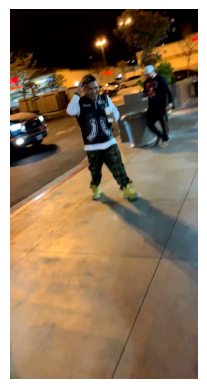

In [58]:


# Check the number of loaded samples
print(f"Number of loaded samples: {len(dataset_df)}")

# Check the first few rows
print(dataset_df.head())

# Check if images are saved correctly
import matplotlib.pyplot as plt

# Display the first image
first_image_path = dataset_df.iloc[0]["image_path"]
first_image = Image.open(first_image_path)
plt.imshow(first_image)
plt.axis("off")
plt.show()

## creating the dataset.csv file

In [59]:


import pandas as pd

# Use the already cleaned dataset
df = dataset_df.head(150)  # or .head(50) if you want fewer

# Verify column names
print("Columns in the dataset:", df.columns)

required_columns = ["tweet_text", "labels", "image_path"]
if not all(col in df.columns for col in required_columns):
    raise KeyError(f"Required columns {required_columns} not found in the dataset.")

# Save to CSV
df.to_csv("dataset/dataset.csv", index=False)

print("Dataset saved successfully. Sample data:")
print(df.head())



Columns in the dataset: Index(['tweet_text', 'image_path', 'labels'], dtype='object')
Dataset saved successfully. Sample data:
                                          tweet_text            image_path  \
0       @FriskDontMiss Nigga https://t.co/cAsaLWEpue  dataset\images\0.jpg   
1     My horses are retarded https://t.co/HYhqc6d5WN  dataset\images\1.jpg   
2  “NIGGA ON MA MOMMA YOUNGBOY BE SPITTING REAL S...  dataset\images\2.jpg   
3  RT xxSuGVNGxx: I ran into this HOLY NIGGA TODA...  dataset\images\3.jpg   
4  “EVERYbody calling you Nigger now!” https://t....  dataset\images\4.jpg   

      labels  
0  [4, 1, 3]  
1  [5, 5, 5]  
2  [0, 0, 0]  
3  [1, 0, 0]  
4  [1, 0, 1]  


In [60]:
clean_data = pd.read_csv("dataset/dataset.csv")
clean_data.head()


,tweet_text,image_path,labels
0,@FriskDontMiss Nigga https://t.co/cAsaLWEpue,dataset\images\0.jpg,"[4, 1, 3]"
1,My horses are retarded https://t.co/HYhqc6d5WN,dataset\images\1.jpg,"[5, 5, 5]"
2,“NIGGA ON MA MOMMA YOUNGBOY BE SPITTING REAL S...,dataset\images\2.jpg,"[0, 0, 0]"
3,RT xxSuGVNGxx: I ran into this HOLY NIGGA TODA...,dataset\images\3.jpg,"[1, 0, 0]"
4,“EVERYbody calling you Nigger now!” https://t....,dataset\images\4.jpg,"[1, 0, 1]"


In [61]:
clean_data.shape

(150, 3)